# Week 7 Data acqusition from OpenBCI

In [2]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt
import pyxdf

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

# OPENBCI

## 1 Read recorded data from OpenBCI (xdf file)

In [3]:
import pyxdf
import mne
import numpy as np
import pandas as pd

df = pd.read_csv('psychopy_data/tai3.csv')
response = df.get(key="response.keys")
response = response[1:-2]
data_response = response.to_numpy()

streams, header = pyxdf.load_xdf("data/sub-thai_ses-S003_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder

if streams[0]['info']['type'][0] == 'Markers': #Check
    raw_stream = streams[1]
    event_data = streams[0]
else:
    raw_stream = streams[0]
    event_data = streams[1]

raw_data = raw_stream["time_series"].T #From Steam variable this query is EEG data
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
raw_OpenBCI = mne.io.RawArray(raw_data, info, verbose=False)    


In [4]:
df.get(key="response.keys")

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13    space
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20    space
21    space
22    space
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29    space
30      NaN
31      NaN
32      NaN
33      NaN
34      NaN
35      NaN
36      NaN
37    space
38      NaN
39      NaN
40      NaN
41      NaN
42      NaN
43      NaN
44      NaN
45      NaN
46      NaN
47    space
48      NaN
49      NaN
50      NaN
51      NaN
52      NaN
Name: response.keys, dtype: object

In [5]:
len(data_response)

50

In [6]:
raw_OpenBCI

<RawArray | 8 x 52550 (210.2 s), ~3.2 MiB, data loaded>

In [7]:
raw_OpenBCI.ch_names

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']

In [8]:
channel_mapping = {
    'CH1': 'Fz',
    'CH2': 'Cz',
    'CH3': 'Pz',
    'CH4': 'Oz',
    'CH5': 'P3',
    'CH6': 'P4',
    'CH7': 'O1',
    'CH8': 'O2'
}

## 2. Filter

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\4197467807.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


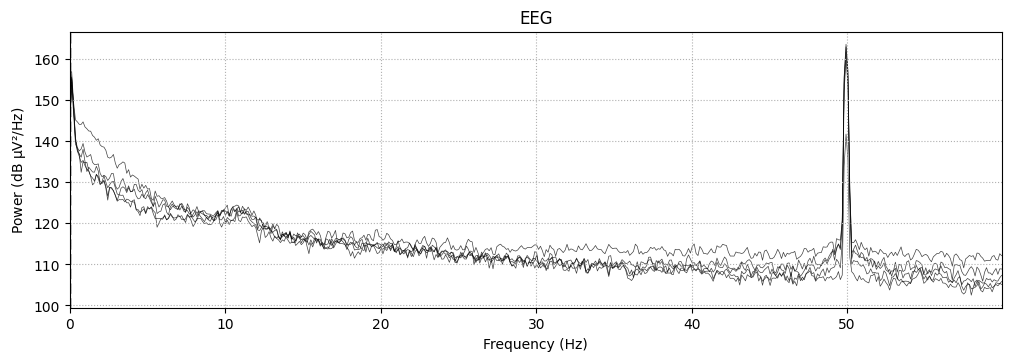

In [9]:
raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\1135962250.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


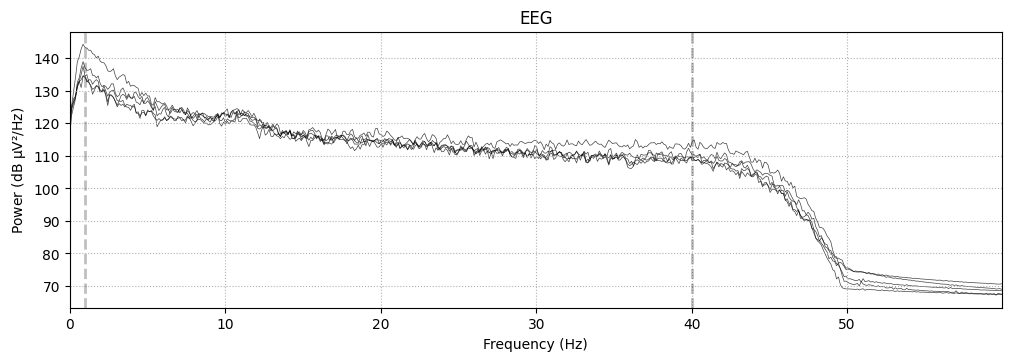

In [10]:
OpenBCI_filter = raw_OpenBCI.copy().filter(l_freq=1, h_freq=40,fir_design='firwin') #band-pass function
OpenBCI_filter = OpenBCI_filter.copy().notch_filter(freqs=50) #notch filter function
OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
OpenBCI_filter.rename_channels(channel_mapping)
OpenBCI_filter.set_montage('standard_1020')
plt.show()


In [11]:
ICA_filtered = raw_OpenBCI.copy().filter(l_freq=1., h_freq=40., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [12]:
ICA_filtered.rename_channels(channel_mapping)
ICA_filtered.set_montage('standard_1020')

<RawArray | 8 x 52550 (210.2 s), ~3.2 MiB, data loaded>

In [13]:
from mne.preprocessing import ICA

ica = ICA(n_components=8, random_state=97, max_iter='auto')
ica.fit(ICA_filtered)


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,25 iterations on raw data (52550 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


In [14]:
from mne_icalabel import label_components
ic_labels = label_components(ICA_filtered, ica, method="iclabel")
ic_labels

C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\1545837569.py:2: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(ICA_filtered, ica, method="iclabel")
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\1545837569.py:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(ICA_filtered, ica, method="iclabel")
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\1545837569.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA dec

{'y_pred_proba': array([0.70553106, 0.8093275 , 0.9352848 , 0.9926163 , 0.9828887 ,
        0.98842824, 0.98863363, 0.98079276], dtype=float32),
 'labels': ['other',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain']}

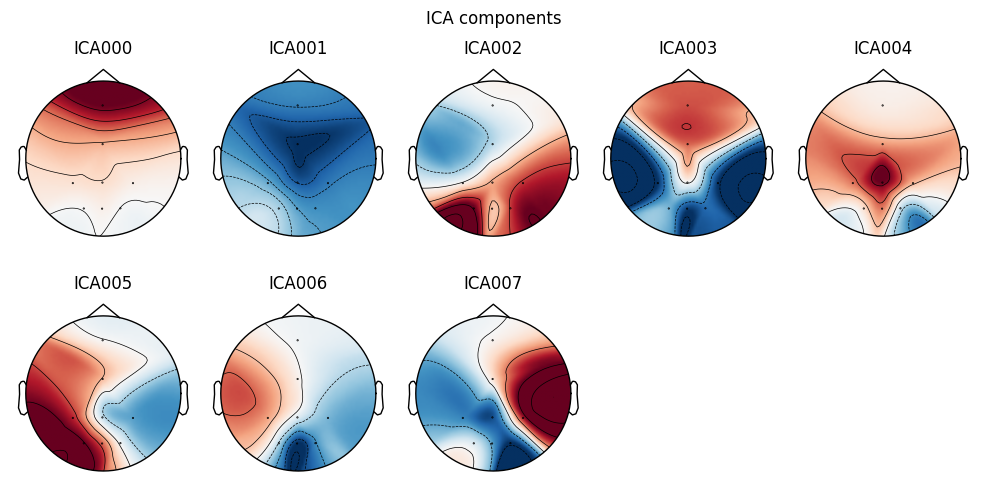

Creating RawArray with float64 data, n_channels=8, n_times=52550
    Range : 0 ... 52549 =      0.000 ...   210.196 secs
Ready.
Using matplotlib as 2D backend.


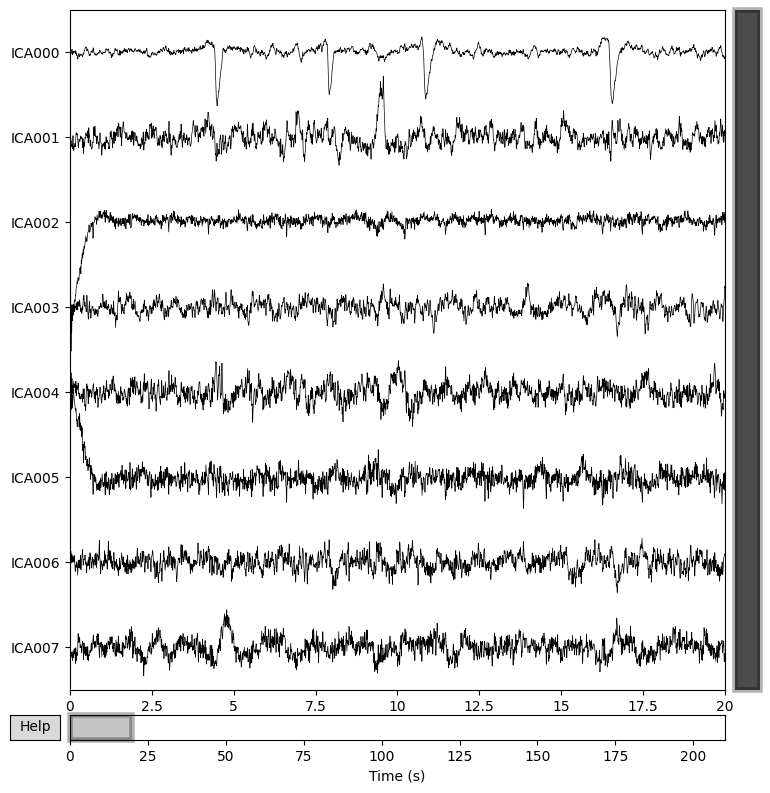

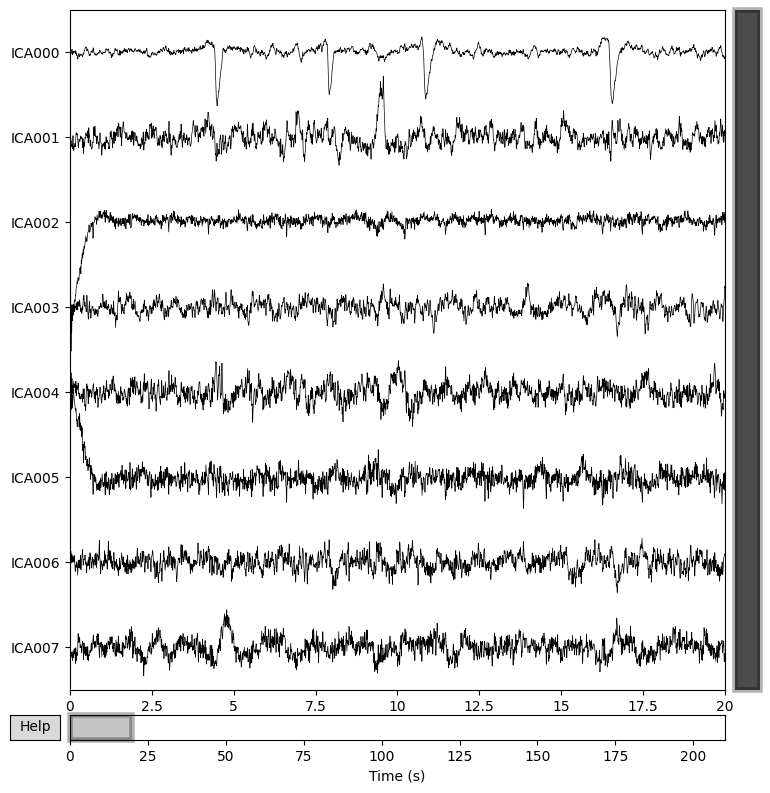

In [15]:
ica.plot_components()
ica.plot_sources(ICA_filtered)

In [16]:
# For example, remove components 0 and 1
ica.exclude = [3]

# Apply ICA to remove the marked components
raw_clean = ica.apply(ICA_filtered.copy())


Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


In [17]:
# OpenBCI_filter = raw_clean.copy()

## 3.Epoching

In [18]:
sfreq= 250
# event_index = np.array(event_data["time_series"]) #Get all event marker of experiment 
event_timestamp = (np.array(event_data["time_stamps"]).T * sfreq) - (raw_stream['time_stamps'][0] * sfreq) #Timestamp when event marked


In [19]:
# event_data["time_series"]

In [20]:
print(len(data_response))

50


In [21]:
event_index = []

for i in range (len(event_data["time_series"])):
    # print(event_data["time_series"][i][0])
    event_index.append(event_data["time_series"][i][0])
    # np.append(event_index,event_data["time_series"][i][0])
np_event_index = np.array(event_index)
print(np_event_index)

['101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101' '201'
 '201' '101' '101' '101' '101' '101' '101' '201' '201' '201' '101' '201'
 '101' '101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101'
 '201' '101' '101' '101' '101' '101' '101' '101' '101' '101' '201' '101'
 '101' '101' '']


Map real response to event

In [22]:
real_event_index = []

for i in range(len(np_event_index)):
    if np_event_index[i] == '101' and data_response[i] != "space":
        real_event_index.append('101')
    elif  np_event_index[i] == '201' and data_response[i] != "space":
        real_event_index.append('301')
    elif np_event_index[i] == '201' and data_response[i] == "space" :
        real_event_index.append('201')
    else:
        real_event_index.append('')
np_real_event_index  = np.array(real_event_index)
print(np_real_event_index)

['101' '101' '101' '301' '101' '101' '101' '101' '101' '101' '101' '301'
 '201' '101' '101' '101' '101' '101' '101' '201' '201' '201' '101' '301'
 '101' '101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101'
 '201' '101' '101' '101' '101' '101' '101' '101' '101' '101' '201' '101'
 '101' '101' '']


In [23]:
# events_id2 = {'U': 1, 'R': 2, 'L': 3, 'D': 4, '': 5}
events_id2 = {'101': 1,'201' : 2,'301' : 3,'': 5}
# # Use vectorized mapping with np.vectorize
# event_index = np.vectorize(events_id2.get)(event_index)
event_index = np.vectorize(events_id2.get)(real_event_index)

In [24]:
# event_data["time_series"]

In [25]:
events2 = np.column_stack((np.array(event_timestamp, dtype = int),np.zeros(len(event_timestamp), dtype = int),np.array(event_index, dtype = int)))


In [26]:
# count mark
# count_101 = 0
# els = 0
# for i in range(len(event_data["time_series"])):
#     if event_data["time_series"][i][0] == '101' :
#         count_101 += 1
#     elif event_data["time_series"][i][0] == '201' :
#         els += 1

# print(count_101,els)

In [27]:
events2

array([[ 3839,     0,     1],
       [ 4829,     0,     1],
       [ 5755,     0,     1],
       [ 6707,     0,     3],
       [ 7619,     0,     1],
       [ 8577,     0,     1],
       [ 9548,     0,     1],
       [10505,     0,     1],
       [11492,     0,     1],
       [12445,     0,     1],
       [13350,     0,     1],
       [14318,     0,     3],
       [15257,     0,     2],
       [16241,     0,     1],
       [17151,     0,     1],
       [18144,     0,     1],
       [19115,     0,     1],
       [20031,     0,     1],
       [20980,     0,     1],
       [21892,     0,     2],
       [22800,     0,     2],
       [23796,     0,     2],
       [24708,     0,     1],
       [25621,     0,     3],
       [26523,     0,     1],
       [27454,     0,     1],
       [28391,     0,     1],
       [29368,     0,     1],
       [30348,     0,     2],
       [31253,     0,     1],
       [32156,     0,     1],
       [33067,     0,     1],
       [34021,     0,     1],
       [34

In [28]:
OpenBCI_epochs = mne.Epochs(OpenBCI_filter, events2, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 2,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id2,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )

Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 626 original time points ...
0 bad epochs dropped


In [29]:
OpenBCI_epochs

<Epochs | 51 events (all good), -0.5 – 2 s (baseline -0.5 – 0 s), ~2.0 MiB, data loaded,
 '101': 40
 '201': 7
 '301': 3
 '': 1>

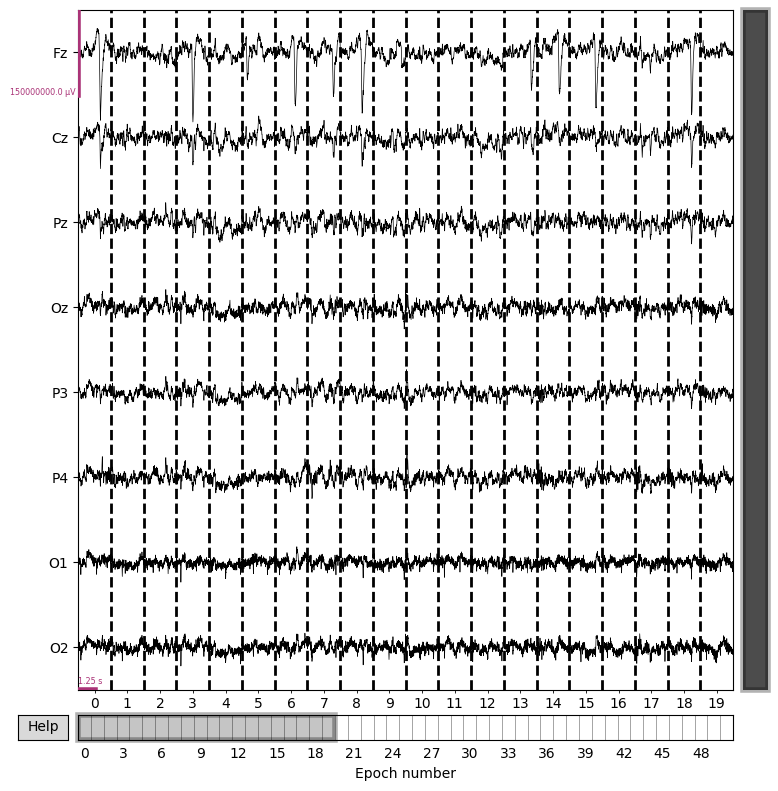

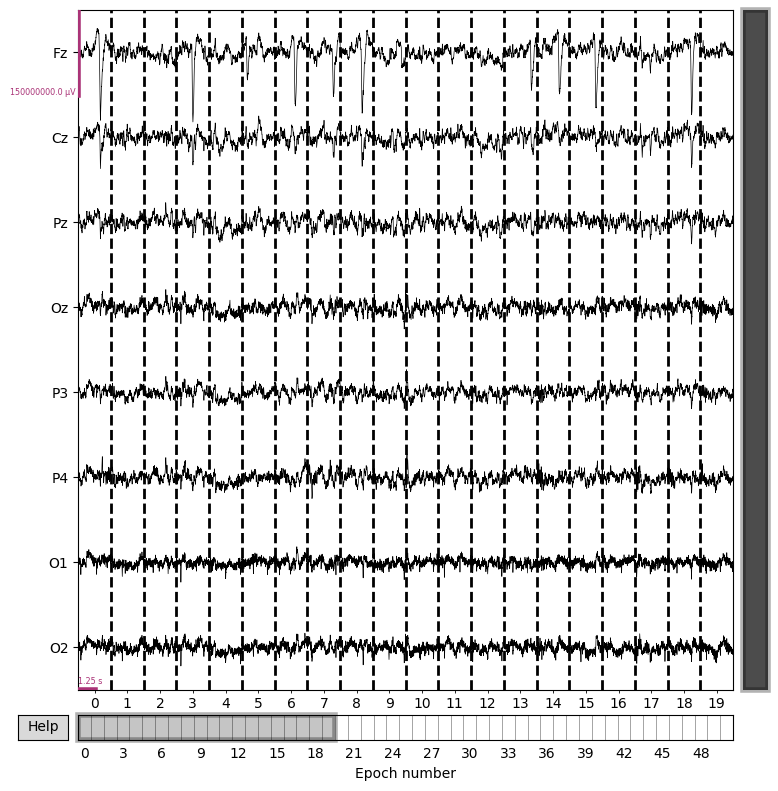

In [30]:
OpenBCI_epochs.plot(scalings = 75)

In [31]:
evoked_target = OpenBCI_epochs['201'].average()
evoked_subtarget = OpenBCI_epochs['301'].average()
evoked_nontarget = OpenBCI_epochs['101'].average()


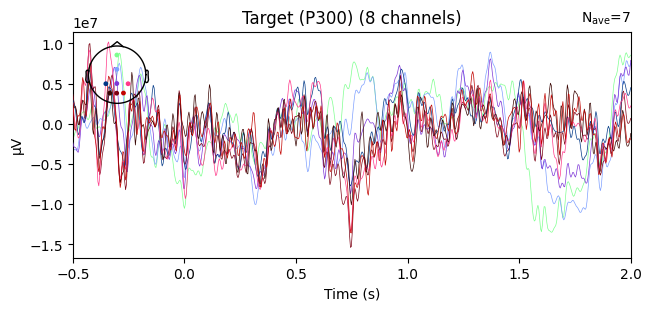

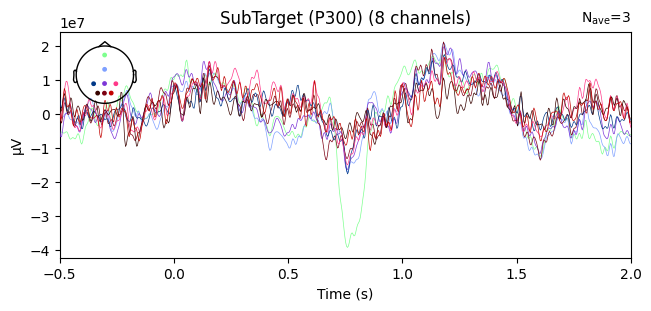

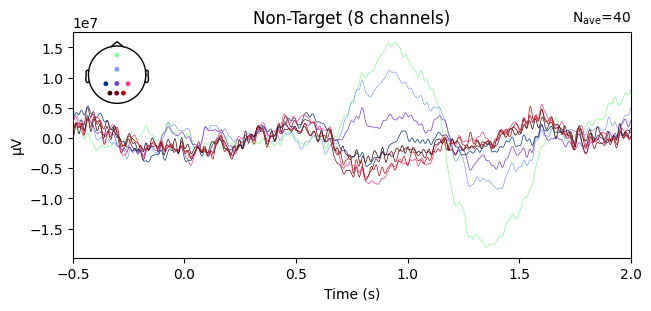

In [32]:
evoked_target.plot(spatial_colors=True, titles='Target (P300)')
evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
evoked_nontarget.plot(spatial_colors=True, titles='Non-Target')
plt.show()


combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\3306011302.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


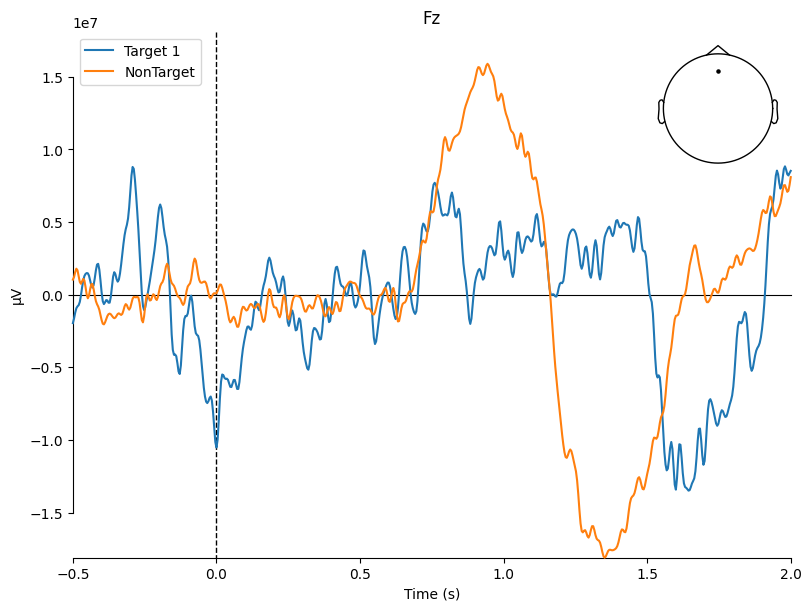

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\3306011302.py:11: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


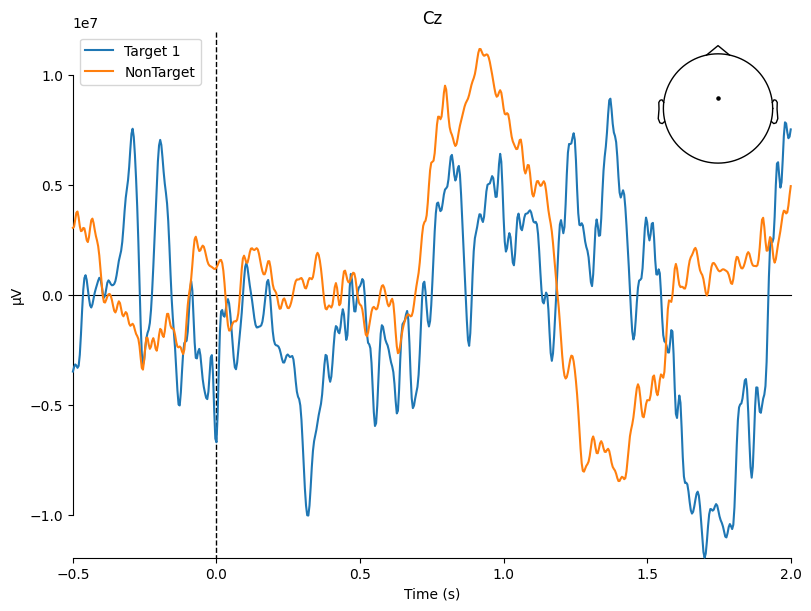

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\3306011302.py:21: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


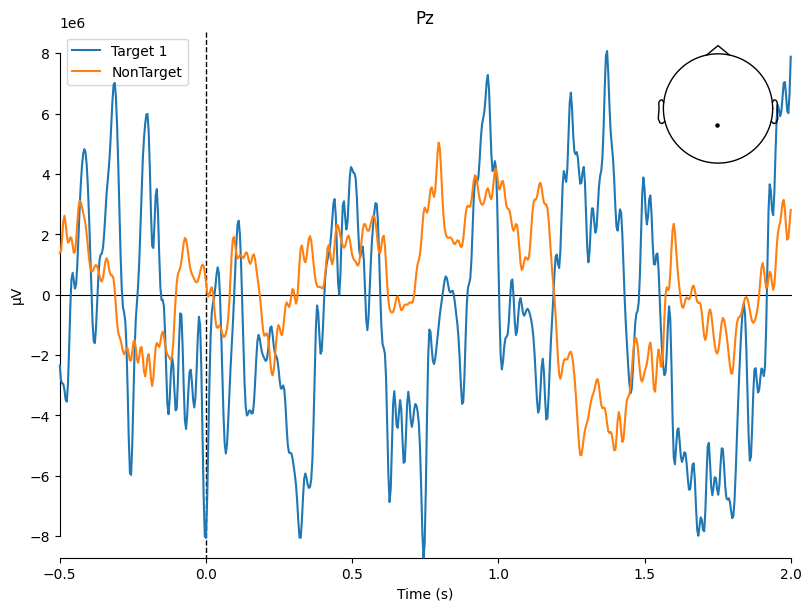

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\3306011302.py:31: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


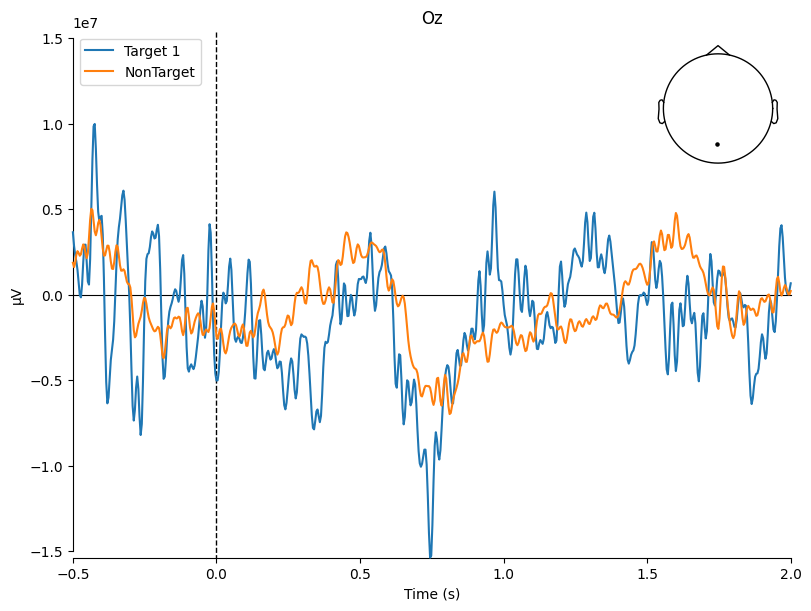

In [46]:
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Fz',
    combine='mean'
)
plt.show()
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Cz',
    combine='mean'
)
plt.show()
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Pz',
    combine='mean'
)

mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Oz',
    combine='mean'
)
plt.show()

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


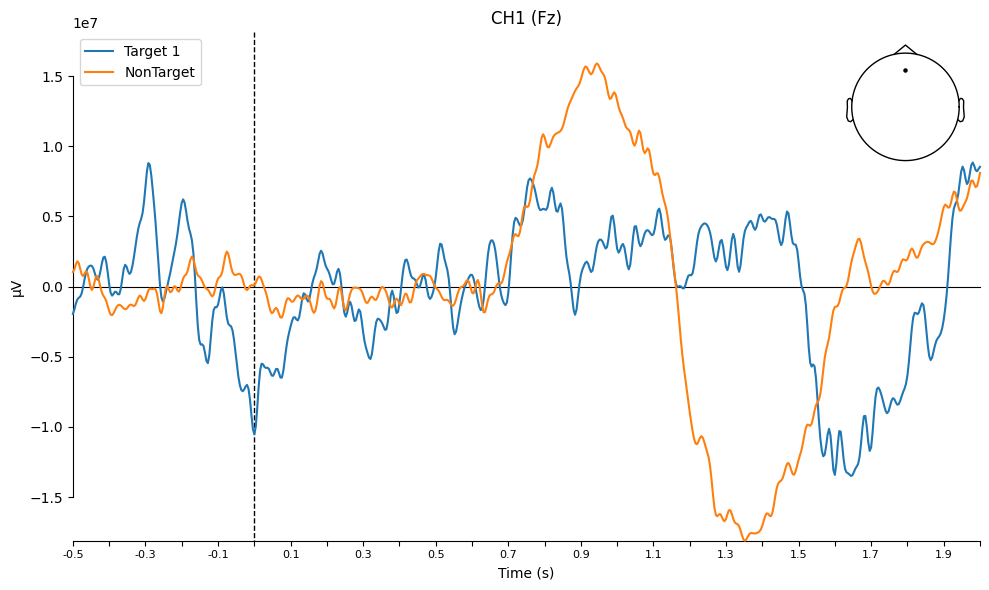

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


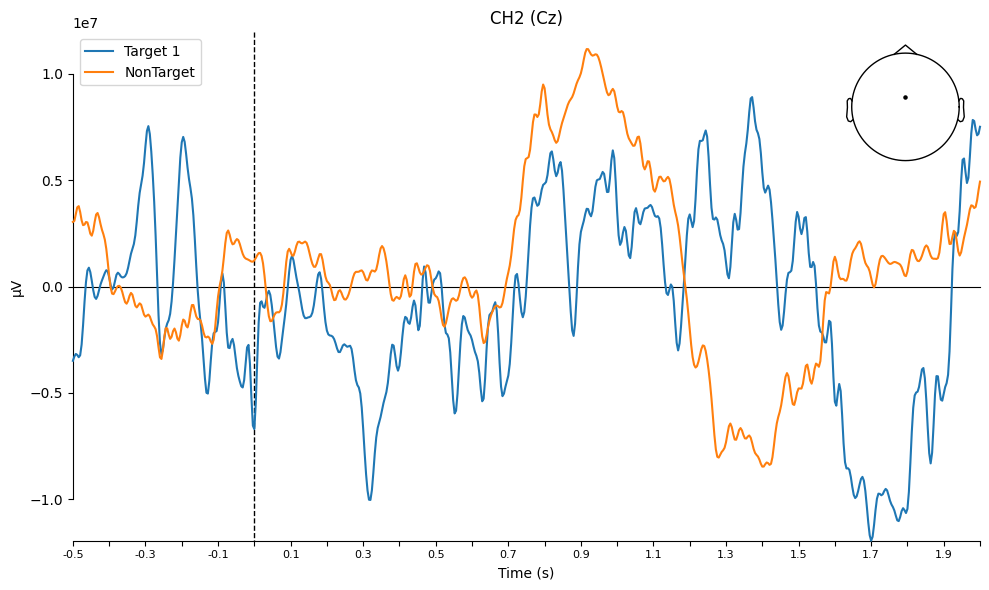

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


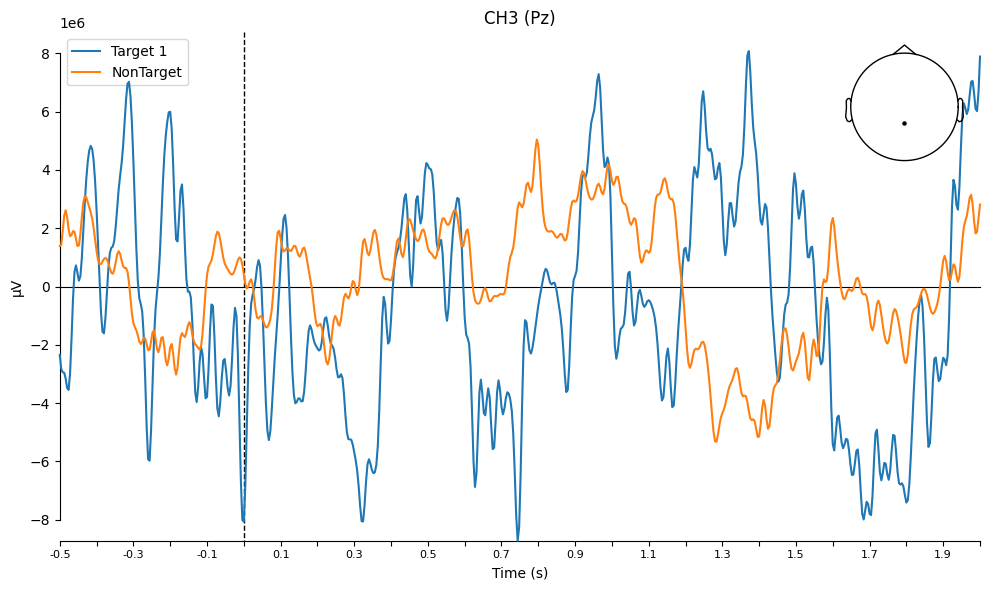

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


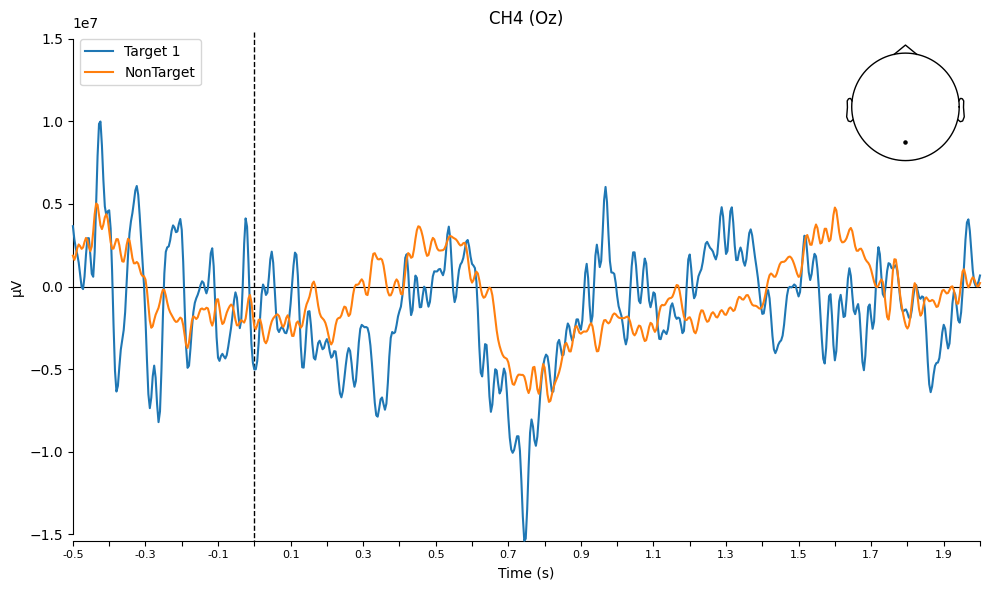

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


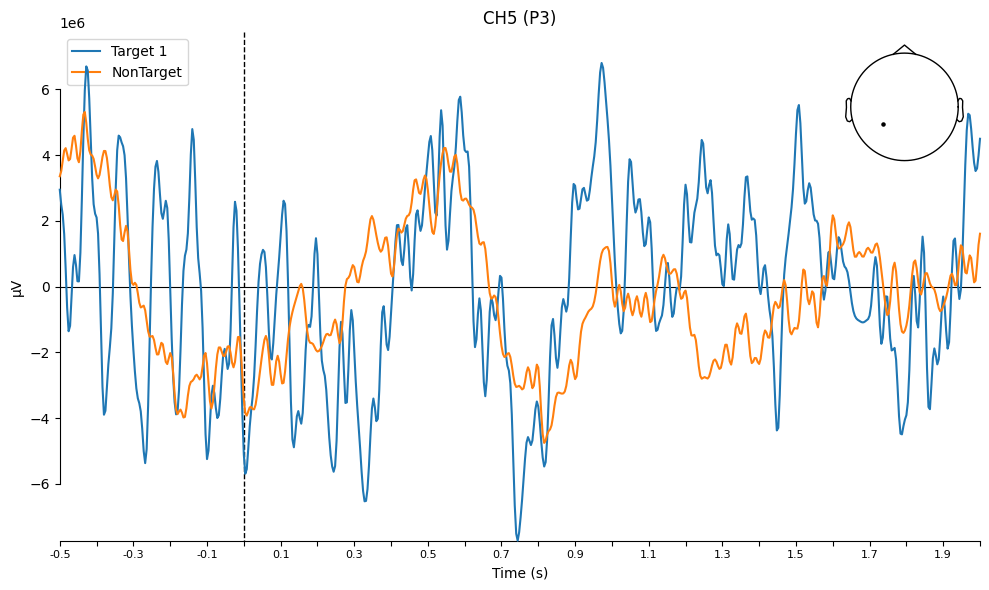

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


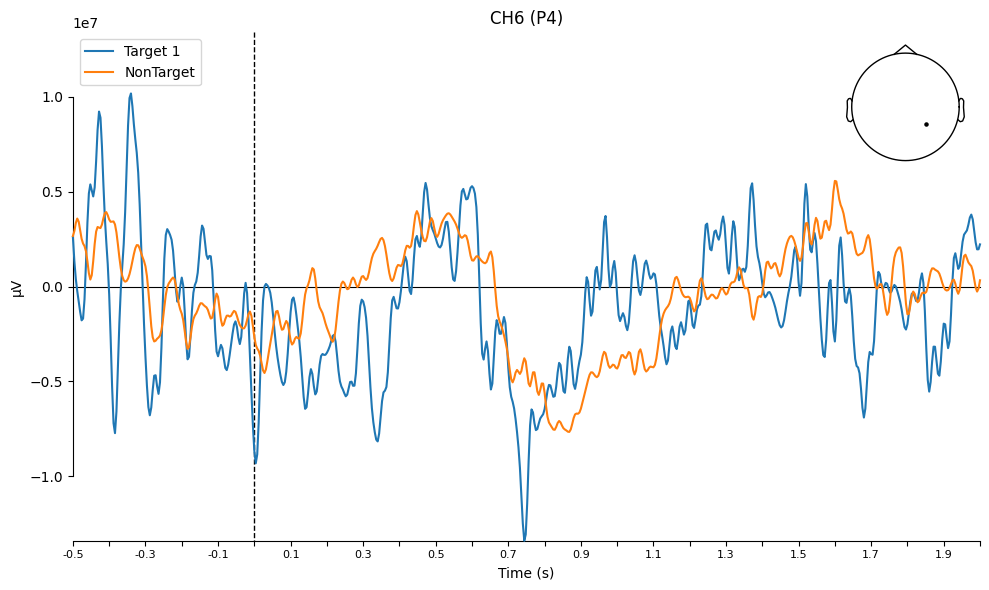

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


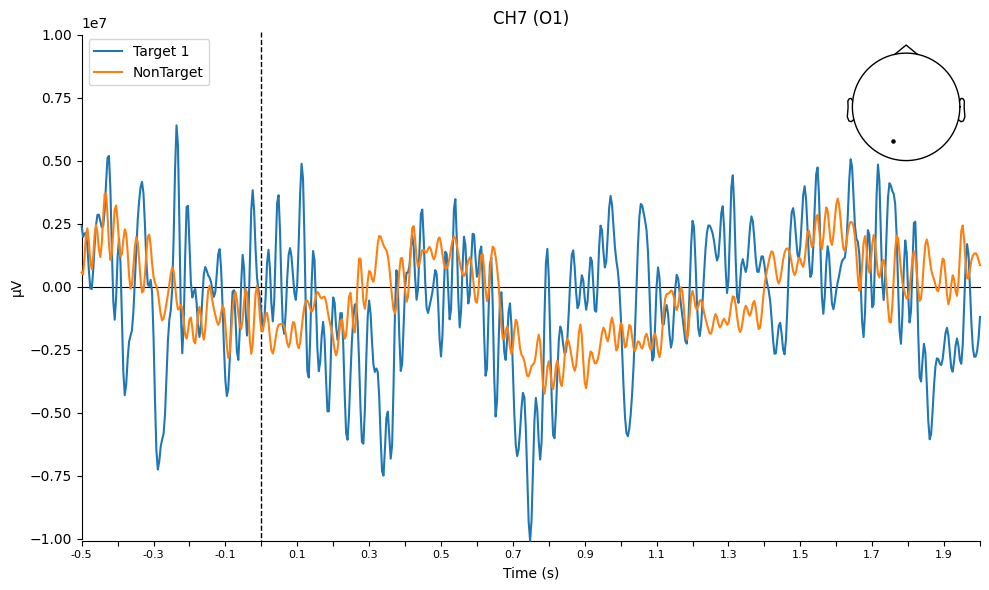

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_46856\133331761.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


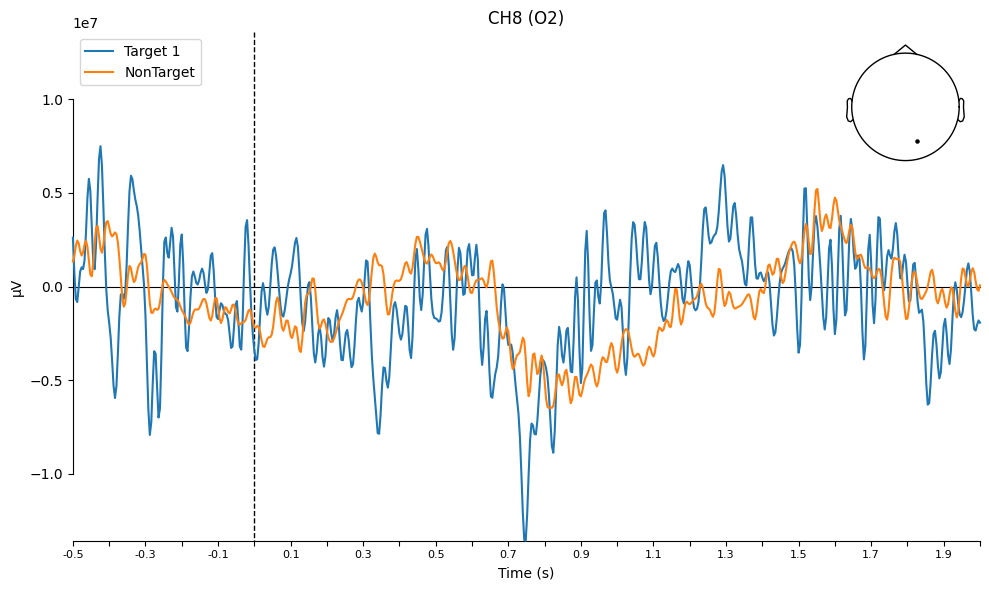

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import mne

# Function to label time axis every 0.1s
def set_time_resolution(ax, evoked_data, step=0.1, label_every_n=2, fontsize=8):
    times = evoked_data.times
    ticks = np.arange(times[0], times[-1] + step, step)
    ax.set_xticks(ticks)

    # Only show every nth label
    labels = [f"{t:.1f}" if i % label_every_n == 0 else "" for i, t in enumerate(ticks)]
    ax.set_xticklabels(labels, fontsize=fontsize)


# Plot for each mapped channel
for ch_label, eeg_ch_name in channel_mapping.items():
    fig, ax = plt.subplots(figsize=(10,6))
    mne.viz.plot_compare_evokeds(
        {
            'Target 1': evoked_target,
            'NonTarget': evoked_nontarget
        },
        picks=eeg_ch_name,
        combine='mean',
        axes=ax,
        show=False
    )
    ax.set_title(f'{ch_label} ({eeg_ch_name})')
    set_time_resolution(ax, evoked_target)  # Optional: set time ticks every 0.1s
    plt.tight_layout()
    plt.show()


In [34]:
montage = mne.channels.make_standard_montage('standard_1020')
OpenBCI_filter.set_montage(montage)  # Apply to your preprocessed Raw object


<RawArray | 8 x 52550 (210.2 s), ~3.2 MiB, data loaded>

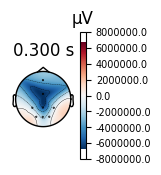

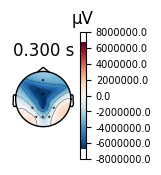

In [35]:
evoked_target = OpenBCI_epochs['201'].average()
evoked_target.plot_topomap(times=[0.3], ch_type='eeg')
